# Maxwell

In [1]:
dataset = "maxwell_pre"

time: 1.43 ms


## Rohe Daten
Baue Datenbankverbindung auf und zeige 3 Beispieldaten aus dem vorbereiteten Datensatz "Desharnais".

In [2]:
from libs.data.Db import Db
import pandas as pd

db = Db().getDb()
desh = db[dataset]

data = pd.DataFrame(
    list(desh.find({}, { 'id': 0, '_id': 0 }))
)

list(desh.find().limit(3))

[{'_id': ObjectId('5cb0a9ed27e2fe003483a240'),
  'Effort': 7871.0,
  'Ifc': 2.0,
  'Source': 2.0,
  'Telonuse': 0.0,
  'Duration': -0.1144995467429915,
  'Nlan': 0.44675795239082206,
  'Size': -0.033824417582639994,
  'Time': 1.1444048226643266,
  'Is_CS': -0.43852900965351455,
  'Is_MIS': 1.0667385033281394,
  'Is_TCLOP': -0.6396021490668312,
  'Is_PCLOP': -0.12803687993289592,
  'Is_IS': -0.2626128657194451,
  'Is_Network': -0.12803687993289592,
  'Is_Mainframe': 0.8219949365267863,
  'Is_PC': -0.5897678246195885,
  'Is_MiniComputer': -0.12803687993289592,
  'Is_MultiPlatform': -0.3567530340063379,
  'Is_NoDba': -0.18257418583505533,
  'Is_Relational': 0.2626128657194453,
  'Is_OtherDba': -0.12803687993289592,
  'Is_Sequential': -0.12803687993289595,
  'Is_T01_VeryLow': -0.22549380840084865,
  'Is_T01_Low': -0.6396021490668313,
  'Is_T01_Nominal': -0.5897678246195885,
  'Is_T01_High': 1.3021720984236467,
  'Is_T01_VeryHigh': -0.18257418583505539,
  'Is_T02_VeryLow': -0.12803687993289

time: 1.11 s


### Data

In [3]:
import pandas as pd

X_data = pd.DataFrame(
    list(desh.find({}, { 'Effort': 0, 'id': 0, '_id': 0 }))
)
y_data = pd.DataFrame(
    list(desh.find({}, { 'Effort': 1, '_id': 0 }))
)
header = list(X_data.columns.values)

time: 61.3 ms


Funktion zum Berechnen der Baumtiefe

In [4]:
def dectree_max_depth(tree):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

time: 5.73 ms


# Multirun

In [5]:
from sklearn.model_selection import train_test_split
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from libs.tree.ModelTree import ModelTree
from sklearn.ensemble import RandomForestRegressor
from libs.forest.RandomForestModelTree import RandomForestModelTree
from sklearn.metrics import make_scorer
from datetime import datetime
import pandas as pd
import numpy as np
import os
import time

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

X = X_data.values
y = np.ravel(y_data.values.astype('float')) # scikit needs to know what kind of problem to solve

n_runs = 30
m_dt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_mt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfdt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfmt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
for i in range(n_runs):
    print("{}/{}".format(i+1, n_runs))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    searchSpace_trees = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }
    
    searchSpace_forests = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None], # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        "bootstrap": [True, False],
        #"oob_score": [True],
        "n_estimators": [20],
        "n_jobs": [-1]
    }
    
    #--------------------------
    print("DT")
    start_time = time.clock()
    
    rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_dt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_dt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_dt.best_params_["criterion"],
            max_depth = rs_dt.best_params_["max_depth"],
            min_samples_split = rs_dt.best_params_["min_samples_split"],
            min_samples_leaf = rs_dt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_dt.best_params_["max_leaf_nodes"],
            max_features = rs_dt.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(dt.tree_)))
        print(Metrics().mer(y_test, y_pred))

    m_dt['mmre'].append(np.mean(mmres))
    m_dt['mdmre'].append(np.mean(mdmres))
    m_dt['pred'].append(np.mean(preds))
    m_dt['mmer'].append(np.mean(mmers))
    m_dt['mdmer'].append(np.mean(mdmers))
    m_dt['mae'].append(np.mean(maes))
    m_dt['mbre'].append(np.mean(mbres))
    m_dt['mibre'].append(np.mean(mibres))
    m_dt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("MT")
    start_time = time.clock()
    
    rs_mt = RandomizedSearchCV(ModelTree(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_mt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_mt.best_params_))
    
    mmres_mt = []
    mdmres_mt = []
    preds_mt = []
    mmers_mt = []
    mdmers_mt = []
    maes_mt = []
    mbres_mt = []
    mibres_mt = []
    sas_mt = []
    for i in range(1):
        mt = ModelTree(
            criterion = rs_mt.best_params_["criterion"],
            max_depth = rs_mt.best_params_["max_depth"],
            min_samples_split = rs_mt.best_params_["min_samples_split"],
            min_samples_leaf = rs_mt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_mt.best_params_["max_leaf_nodes"],
            max_features = rs_mt.best_params_["max_features"]
        )
        mt.fit(X_train, y_train)
        y_pred = mt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_mt.append(metrics['mmre'])
        mdmres_mt.append(metrics['mdmre'])
        preds_mt.append(metrics['pred'])
        mmers_mt.append(metrics['mmer'])
        mdmers_mt.append(metrics['mdmer'])
        maes_mt.append(metrics['mae'])
        mbres_mt.append(metrics['mbre'])
        mibres_mt.append(metrics['mibre'])
        sas_mt.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(mt.tree_)))
        print(Metrics().mer(y_test, y_pred))

    m_mt['mmre'].append(np.mean(mmres_mt))
    m_mt['mdmre'].append(np.mean(mdmres_mt))
    m_mt['pred'].append(np.mean(preds_mt))
    m_mt['mmer'].append(np.mean(mmers_mt))
    m_mt['mdmer'].append(np.mean(mdmers_mt))
    m_mt['mae'].append(np.mean(maes_mt))
    m_mt['mbre'].append(np.mean(mbres_mt))
    m_mt['mibre'].append(np.mean(mibres_mt))
    m_mt['sa'].append(np.mean(sas_mt))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFDT")
    start_time = time.clock()
    
    rs_rfdt = RandomizedSearchCV(RandomForestRegressor(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfdt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfdt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfdt = RandomForestRegressor(
            criterion = rs_rfdt.best_params_["criterion"],
            max_depth = rs_rfdt.best_params_["max_depth"],
            min_samples_split = rs_rfdt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfdt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfdt.best_params_["max_leaf_nodes"],
            max_features = rs_rfdt.best_params_["max_features"],
            bootstrap = rs_rfdt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfdt.fit(X_train, y_train)
        y_pred = rfdt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print(Metrics().mer(y_test, y_pred))

    m_rfdt['mmre'].append(np.mean(mmres))
    m_rfdt['mdmre'].append(np.mean(mdmres))
    m_rfdt['pred'].append(np.mean(preds))
    m_rfdt['mmer'].append(np.mean(mmers))
    m_rfdt['mdmer'].append(np.mean(mdmers))
    m_rfdt['mae'].append(np.mean(maes))
    m_rfdt['mbre'].append(np.mean(mbres))
    m_rfdt['mibre'].append(np.mean(mibres))
    m_rfdt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFMT")
    start_time = time.clock()
    
    rs_rfmt = RandomizedSearchCV(RandomForestModelTree(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfmt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfmt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfmt = RandomForestModelTree(
            criterion = rs_rfmt.best_params_["criterion"],
            max_depth = rs_rfmt.best_params_["max_depth"],
            min_samples_split = rs_rfmt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfmt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfmt.best_params_["max_leaf_nodes"],
            max_features = rs_rfmt.best_params_["max_features"],
            bootstrap = rs_rfmt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfmt.fit(X_train, y_train)
        y_pred = rfmt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print(Metrics().mer(y_test, y_pred))

    m_rfmt['mmre'].append(np.mean(mmres))
    m_rfmt['mdmre'].append(np.mean(mdmres))
    m_rfmt['pred'].append(np.mean(preds))
    m_rfmt['mmer'].append(np.mean(mmers))
    m_rfmt['mdmer'].append(np.mean(mdmers))
    m_rfmt['mae'].append(np.mean(maes))
    m_rfmt['mbre'].append(np.mean(mbres))
    m_rfmt['mibre'].append(np.mean(mibres))
    m_rfmt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))

print("DT:")
print("MMRE: {}\n{}".format(np.mean(m_dt['mmre']), m_dt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_dt['mdmre']), m_dt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_dt['pred']), m_dt['pred']))
print("MMER: {}\n{}".format(np.mean(m_dt['mmer']), m_dt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_dt['mdmer']), m_dt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_dt['mae']), m_dt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_dt['mbre']), m_dt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_dt['mibre']), m_dt['mibre']))
print("SA: {}\n{}".format(np.mean(m_dt['sa']), m_dt['sa']))
print("------------------------------------------------")
print("MT:")
print("MMRE: {}\n{}".format(np.mean(m_mt['mmre']), m_mt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_mt['mdmre']), m_mt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_mt['pred']), m_mt['pred']))
print("MMER: {}\n{}".format(np.mean(m_mt['mmer']), m_mt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_mt['mdmer']), m_mt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_mt['mae']), m_mt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_mt['mbre']), m_mt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_mt['mibre']), m_mt['mibre']))
print("SA: {}\n{}".format(np.mean(m_mt['sa']), m_mt['sa']))
print("------------------------------------------------")
print("RFDT:")
print("MMRE: {}\n{}".format(np.mean(m_rfdt['mmre']), m_rfdt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfdt['mdmre']), m_rfdt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfdt['pred']), m_rfdt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfdt['mmer']), m_rfdt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfdt['mdmer']), m_rfdt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfdt['mae']), m_rfdt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfdt['mbre']), m_rfdt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfdt['mibre']), m_rfdt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfdt['sa']), m_rfdt['sa']))
print("------------------------------------------------")
print("RFMT:")
print("MMRE: {}\n{}".format(np.mean(m_rfmt['mmre']), m_rfmt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfmt['mdmre']), m_rfmt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfmt['pred']), m_rfmt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfmt['mmer']), m_rfmt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfmt['mdmer']), m_rfmt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfmt['mae']), m_rfmt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfmt['mbre']), m_rfmt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfmt['mibre']), m_rfmt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfmt['sa']), m_rfmt['sa']))
print("------------------------------------------------")

1/30
DT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 15, 'max_features': 52, 'max_depth': 11, 'criterion': 'mse'}
maxwell_pre_1555097001365.csv
Tree-depth: 8
[0.13780531738597881, 0.3912888798536287, 0.13605407603171371, 2.8963414634146338, 0.42787227076117113, 0.5661935297932128, 1.2432605905006417, 0.44024539454410727, 0.44024549639143029, 0.56698547127108123, 0.11608050416751367, 0.060331903014010237, 0.73393982516771705]
time: 10.833776 (HT: 10.795606)
MT
best params: {'min_samples_split': 0.15, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 15, 'max_features': 31, 'max_depth': 20, 'criterion': 'mse'}
maxwell_pre_1555097019682.csv
Tree-depth: 6
[0.088129734879059549, 0.2514184215251079, 0.1618181693287998, 0.031140967248082886, 0.45173308105658477, 0.45636512473335261, 0.90479636389721108, 0.12306929176267219, 0.069882338785432527, 0.33847509836288009, 0.25843717984274694, 0.31704472439868897, 0.51888744002156928]
time: 11.232076 (HT: 11.17382299

best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 10, 'max_features': 31, 'max_depth': 10, 'criterion': 'mae'}
maxwell_pre_1555102724017.csv
Tree-depth: 4
[0.63243243243243241, 0.67940540540540539, 0.10925862658011616, 0.00034164673727365904, 3.3759428344581184, 1.8205637157602224, 0.8185496420790539, 1.2143707820563716, 0.21357681619690352, 0.73700591347650168, 0.31465919701213818, 0.64271536323938072, 0.65764083411142238]
time: 7.64529200000004 (HT: 7.605312000000026)
MT
best params: {'min_samples_split': 0.15, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 10, 'max_features': 72, 'max_depth': 13, 'criterion': 'mse'}
maxwell_pre_1555102738914.csv
Tree-depth: 7
[0.31162206777099472, 0.24620788847853914, 0.011216209594175762, 2.0567585278981433, 2.4437165892748127, 0.16446712714024456, 0.94963274961894772, 1.2938272557247699, 0.84569718013300144, 0.35653684107528449, 0.062557711068098251, 0.24891219024128153, 0.12044813934998344]
time: 8.129251999999951 (

[0.066512084596524412, 0.13553636986532627, 0.47297235968805496, 0.680120831694495, 1.1149469629145341, 0.0033517806594499724, 0.89254114309574528, 0.70075019805058081, 0.54499274251657448, 0.04287002656997544, 1.1865992595558428, 0.18297594236492362, 0.76111692922127905]
time: 40.94032100000004 (HT: 34.63500600000009)
9/30
DT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.4, 'max_leaf_nodes': 10, 'max_features': 11, 'max_depth': 13, 'criterion': 'mae'}
maxwell_pre_1555106779913.csv
Tree-depth: 2
[0.61954732510288069, 1.9610244988864143, 0.88004115226337454, 0.46408685968819602, 0.086213991769547318, 0.53312757201646088, 0.3991769547325103, 0.27018374164810688, 0.083127572016460899, 0.8261316872427984, 0.36567371937639198, 0.81481481481481477, 0.82836859688195996]
time: 5.784673999999995 (HT: 5.765381999999931)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 5, 'max_features': 77, 'max_depth': 9, 'criterion': 'mse'}
maxwell_pre_1555

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.05, 'max_leaf_nodes': None, 'max_features': 96, 'max_depth': 14, 'criterion': 'mae', 'bootstrap': False}
maxwell_pre_1555110778958.csv
[1.4262850082078156, 0.12416172416661977, 0.68814325445330626, 0.85506107714091939, 0.14339318569523032, 0.5386323584357855, 0.21963601776967978, 0.54255968660265563, 0.70409022318287484, 0.67522394980968503, 0.46873122849613968, 0.19742418849676002, 0.46926276417005358]
time: 47.966083000000026 (HT: 34.53478599999994)
13/30
DT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 95, 'max_depth': 2, 'criterion': 'mae'}
maxwell_pre_1555110798472.csv
Tree-depth: 4
[0.62367957746478875, 0.78369819633760152, 0.18181818181818182, 0.24005231997797052, 0.073943661971830985, 0.20647058823529413, 0.057971014492753624, 0.18411164787976383, 1.0006488590894345, 0.23181818181818181, 1.4798711755233493, 1.5668456560649868,

[0.48731909785457522, 0.53905436867358947, 0.22228851035572034, 0.20862065026906898, 0.56271595161916566, 0.45180883506173736, 0.40025899023577033, 0.48840908739903316, 0.19832945648825093, 0.21837110780173674, 0.11199064664971703, 0.048842982238018216, 0.40424144465899853]
time: 34.55139899999995 (HT: 32.473952000000054)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 20, 'max_features': 94, 'max_depth': 16, 'criterion': 'mae', 'bootstrap': True}
maxwell_pre_1555114790405.csv
[0.048111896374908807, 0.52739460080316181, 0.37775966821445817, 0.16309972941815623, 0.57930483917209896, 0.45484718222514781, 0.2501284402937976, 0.42324437490592098, 0.26135939270420566, 0.27948441678820152, 0.25430892922003756, 0.010786798221877931, 0.19512802773674798]
time: 45.72754800000007 (HT: 34.93323699999996)
17/30
DT
best params: {'min_samples_split': 0.15, 'min_samples_leaf': 0.3, 'max_leaf_nodes': 5, 'max_features': 39, 'ma

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 10, 'max_features': 72, 'max_depth': 12, 'criterion': 'mse', 'bootstrap': True}
maxwell_pre_1555118244054.csv
[0.49231984702179149, 0.52741561037016382, 0.32146937818272758, 0.19114321879905788, 0.67428633563396212, 0.50453117958720561, 0.1858266054929579, 0.46480011339094673, 0.066502352945360152, 0.030550973941096651, 0.25615031103250424, 0.58701369072854126, 0.049475137733949265]
time: 34.08654299999989 (HT: 32.217050999999856)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.15, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 15, 'max_features': 35, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': False}
maxwell_pre_1555118826532.csv
[0.53309912167211526, 0.53640399960457175, 0.46285792283193689, 0.0099883869350954821, 0.65469754576397443, 0.64210340166927515, 0.0044025989887601733, 0.59483831605214399, 0.028375930921252027, 0.2321052556807106

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 5, 'max_features': 48, 'max_depth': 20, 'criterion': 'mse', 'bootstrap': False}
maxwell_pre_1555122244572.csv
[0.030263294784009021, 0.49585292118115443, 0.034722804704940338, 0.32879806768111447, 0.26277074958542823, 0.56269349553859294, 0.067137399957168539, 0.56537527355898565, 0.092439381180438582, 0.56901633436005594, 0.13178362058402829, 0.54246307122018089, 0.1362807326241508]
time: 33.23675599999979 (HT: 31.54148699999996)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.05, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 54, 'max_depth': None, 'criterion': 'mae', 'bootstrap': True}
maxwell_pre_1555122805535.csv
[0.44865776914943067, 0.37411555962687404, 0.14058177434557551, 0.035118008875039582, 0.68600878581312952, 0.53656880664341056, 0.35760760565779542, 0.52788973675279038, 0.21985766264603382, 0.46462661336604649,

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.3, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 20, 'max_features': 81, 'max_depth': 7, 'criterion': 'mse', 'bootstrap': False}
maxwell_pre_1555126264027.csv
[0.14342785135283065, 0.83719017238928117, 0.54927944705897047, 2.4551003957081297, 0.17415535066988272, 0.091823921971474987, 0.24135295456239847, 0.31626713078819335, 2.1768067997929883, 0.21125863619516427, 0.15922514181196928, 0.55439413899832957, 0.21742009905348986]
time: 33.49616600000036 (HT: 31.625303000000258)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 15, 'max_features': 17, 'max_depth': 4, 'criterion': 'mse', 'bootstrap': False}
maxwell_pre_1555126838937.csv
[0.097870953425928706, 0.49411679545668358, 0.49760291393867645, 1.7088135281837731, 0.1160215306082006, 0.54755470347664137, 0.25126618314061888, 0.43076885577528562, 0.049170112312058555, 0.30295373929746222, 0.028813

## Vergleich

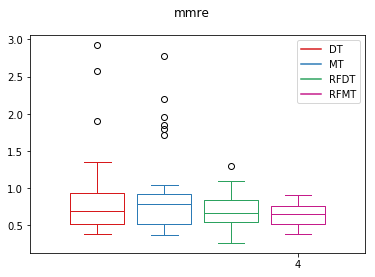

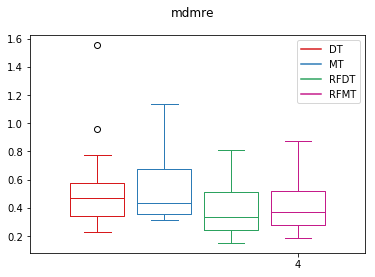

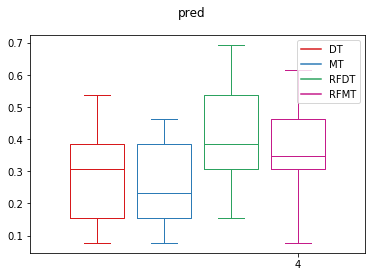

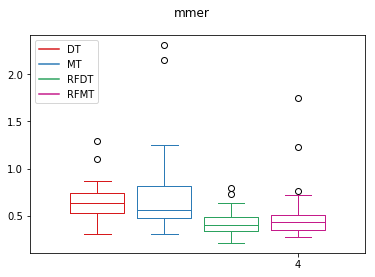

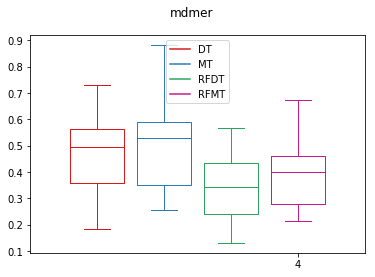

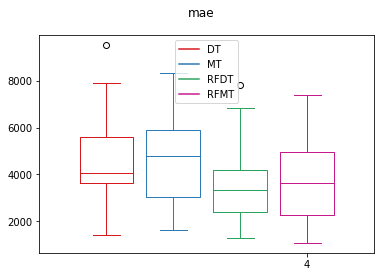

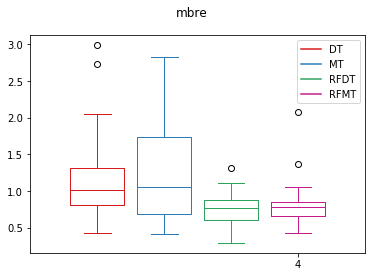

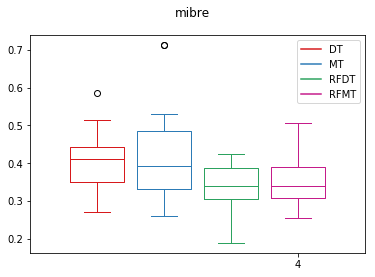

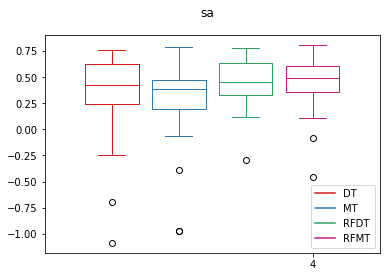

time: 2.7 s


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']

for item in ticks:
    fig, ax = plt.subplots()
    fig.suptitle("{}".format(item))
    bpll = ax.boxplot(m_dt[item], positions=[1], widths=0.8)
    bplr = ax.boxplot(m_mt[item], positions=[2], widths=0.8)
    bprl = ax.boxplot(m_rfdt[item], positions=[3], widths=0.8)
    bprr = ax.boxplot(m_rfmt[item], positions=[4], widths=0.8)
    set_box_color(bpll, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bplr, '#2C7BB6')
    set_box_color(bprl, '#2CA25F')
    set_box_color(bprr, '#C51B8A')
    ax.plot([], c='#D7191C', label='DT')
    ax.plot([], c='#2C7BB6', label='MT')
    ax.plot([], c='#2CA25F', label='RFDT')
    ax.plot([], c='#C51B8A', label='RFMT')
    ax.legend()
    plt.xlim(0, 5)

plt.show()

In [7]:
methods = ['dt', 'mt', 'rfdt', 'rfmt']
greater_is_better = [False, False, True, False, False, False, False, False, True]
ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']
for j, t in enumerate(ticks):
    values = []
    values.append(np.mean(m_dt[t]))
    values.append(np.mean(m_mt[t]))
    values.append(np.mean(m_rfdt[t]))
    values.append(np.mean(m_rfmt[t]))
    values_s = sorted(values, reverse = greater_is_better[j])
    rank = {}
    for i, method in enumerate(methods):
        c = values.index(values_s[i])
        rank[methods[c]] = i
        
    print("\t{}".format(t.upper()), end='', flush=True)
    for i, method in enumerate(methods):
        print(" & \cellcolor{{gr0{}}} {:.4f}".format(rank[method]+1, values[i]), end='', flush=True)
        
    print(" \\\\")

	MMRE & \cellcolor{gr03} 0.8948 & \cellcolor{gr04} 0.9480 & \cellcolor{gr02} 0.6855 & \cellcolor{gr01} 0.6500 \\
	MDMRE & \cellcolor{gr03} 0.5026 & \cellcolor{gr04} 0.5234 & \cellcolor{gr01} 0.3816 & \cellcolor{gr02} 0.4162 \\
	PRED & \cellcolor{gr03} 0.2821 & \cellcolor{gr04} 0.2641 & \cellcolor{gr01} 0.3949 & \cellcolor{gr02} 0.3641 \\
	MMER & \cellcolor{gr03} 0.6552 & \cellcolor{gr04} 0.7572 & \cellcolor{gr01} 0.4310 & \cellcolor{gr02} 0.5008 \\
	MDMER & \cellcolor{gr03} 0.4690 & \cellcolor{gr04} 0.4899 & \cellcolor{gr01} 0.3429 & \cellcolor{gr02} 0.3854 \\
	MAE & \cellcolor{gr03} 4560.9987 & \cellcolor{gr04} 4671.0478 & \cellcolor{gr01} 3549.4024 & \cellcolor{gr02} 3732.3341 \\
	MBRE & \cellcolor{gr03} 1.1469 & \cellcolor{gr04} 1.2854 & \cellcolor{gr01} 0.7784 & \cellcolor{gr02} 0.8035 \\
	MIBRE & \cellcolor{gr03} 0.4031 & \cellcolor{gr04} 0.4199 & \cellcolor{gr01} 0.3381 & \cellcolor{gr02} 0.3473 \\
	SA & \cellcolor{gr03} 0.3235 & \cellcolor{gr04} 0.2674 & \cellcolor{gr02} 0.4475 